<a href="https://colab.research.google.com/github/crossingchen/cesar-vs-greek-salad-image-classifier/blob/main/cesar_vs_greek_salad_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Install Packages

In [ ]:
!pip install -Uqq fastai duckduckgo_search

In [10]:
import os

from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.utils import download_images, resize_images, verify_images, get_image_files
from fastai.data.all import *
from fastai.vision.all import *
from fastdownload import download_url

### 2. Search Image Function

In [16]:
def search_images(term, max_images=30):
  '''Do a search on term and return a list of image urls of length max_images.

  Args:
  term (str): search term for internet image search
  max_images (int, optional): total number of images to return.

  Returns:
  list
  '''

  print(f"Searching for image of '{term}'")
  with DDGS() as ddgs:
      ddgs_images_gen = ddgs.images(
      keywords=term,
      max_results=max_images
      )
      return L(ddgs_images_gen).itemgot('image')

### 3. Get Images

Searching for image of 'cesar salad'


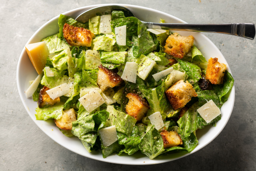

In [17]:
# Download a single image of Cesar Salad
urls = search_images('cesar salad', 1)

dest = 'cesar_salad_1'
img = download_url(urls[0], dest, show_progress=False)

im = Image.open(img)
im.to_thumb(256, 256)

Searching for image of 'greek salad'


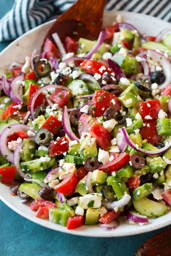

In [18]:
# Download a single image of Greek Salad
urls = search_images('greek salad', 1)

dest = 'greek_salad_1'
img = download_url(urls[0], dest, show_progress=False)

im = Image.open(img)
im.to_thumb(256, 256)

In [20]:
# Search for the two kinds of salads and save to different folders
searches = 'cesar salad', 'greek salad'
path = Path('cesar_or_greek_salads')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images(o)
    download_images(dest, urls=results[:200])
    resize_images(dest, max_size=400, dest=dest)

Searching for image of 'cesar salad'
Searching for image of 'greek salad'


In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

### 4. Train Model

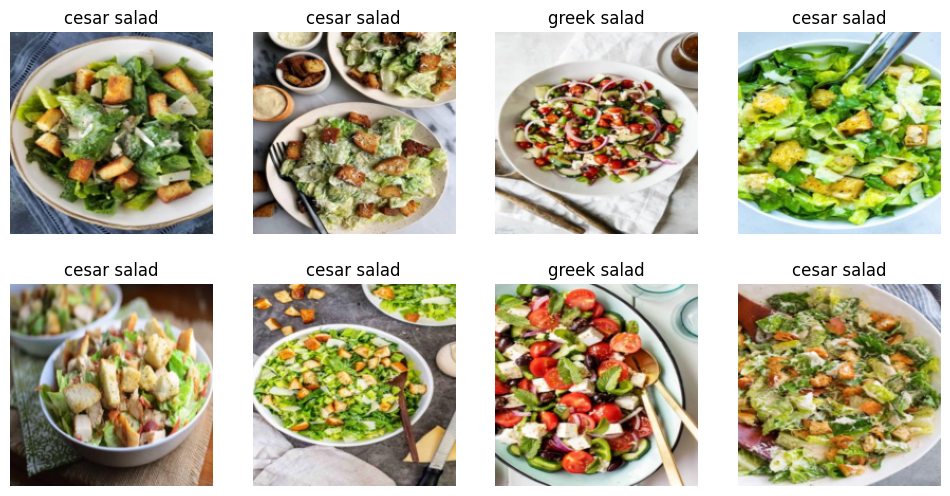

In [26]:
# Create data block of images and labels
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

In [39]:
# Fine tune resnet18 for 3 epochs
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,error_rate,time
0,1.795142,1.454534,0.545455,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.237880,1.213464,0.363636,00:12
1,1.026508,1.012941,0.272727,00:08
2,0.835515,0.874822,0.181818,00:07


### 5. Test Model

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Test image


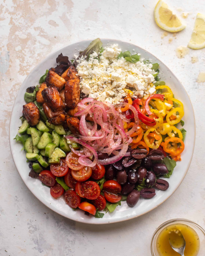

Model prediction:
This is a : greek salad.
Probability this is a greek salad: 0.028864


In [40]:
# Predict test salad image
test_img = 'lemon-salmon-greek-salad-8.jpg'

is_greek,_,proba = learn.predict(PILImage.create(test_img))

print('Test image')
im = Image.open(test_img)
display(im.to_thumb(256,256))

print('Model prediction:')
print(f"This is a : {is_greek}.")
print(f"Probability this is a greek salad: {proba[0]:.6f}")


Test image


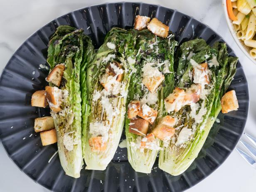

Model prediction:
This is a : cesar salad.
Probability this is a cesar salad: 0.101075


In [41]:
# Predict a cesar salad
test_img = 'grilled-garlic-cesar-salad.jpeg'

is_greek,_,proba = learn.predict(PILImage.create(test_img))

print('Test image')
im = Image.open(test_img)
display(im.to_thumb(256,256))

print('Model prediction:')
print(f"This is a : {is_greek}.")
print(f"Probability this is a cesar salad: {1-proba[0]:.6f}")